#### Imports

In [1]:
import numpy as np
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

#### Load data

In [2]:
# Load the .npz file
# data = np.load('../data/skewness/skewness_multinomial_n6.npz')
# data = np.load('../data/skewness/skewness_multinomial_n6_lesszeros.npz')
# data = np.load('../data/skewness/skewness_multinomial_n6_additional_features.npz')
# data = np.load('../data/skewness/skewness_multinomial_n6_additional_features_xfield_zfield.npz')
data = np.load('../data/skewness/skewness_multinomial_n6_additional_features_bessel.npz')
# data = np.load('../data/skewness/skewness_multinomial_n6_additional_features_bessel_xfield_zfield.npz')

# Access the arrays
frustr_series = data['frustr_series']
mean_series = data['mean_series']
variance_series = data['variance_series']
skewness_series = data['skewness_series']
kurtosis_series = data['kurtosis_series']
fifth_mom_series = data['fifth_mom_series']
sixth_mom_series = data['sixth_mom_series']
pos_ratio_series = data['pos_ratio_series']

# Print the arrays to verify
print('frustr_series:', len(frustr_series))
print('skewness_series:', len(skewness_series))

# Remove elements of specific class/classes
for i in [4]:
    idx_to_remove = np.where(frustr_series == i)
    print('idx_to_remove:', idx_to_remove)
    frustr_series = np.delete(frustr_series, idx_to_remove)
    mean_series = np.delete(mean_series, idx_to_remove)
    variance_series = np.delete(variance_series, idx_to_remove)
    skewness_series = np.delete(skewness_series, idx_to_remove)
    kurtosis_series = np.delete(kurtosis_series, idx_to_remove)
    fifth_mom_series = np.delete(fifth_mom_series, idx_to_remove)
    sixth_mom_series = np.delete(sixth_mom_series, idx_to_remove)

# # Limit to classify between frustrated / non-frustrated
# for i in [2, 3, 4]:
#     idx_to_change = np.where(frustr_series == i)
#     print('idx_to_change:', idx_to_change)
#     frustr_series[idx_to_change] = 1

for i in range(len(skewness_series)):
    if np.isnan(skewness_series[i]):
        mean_series[i] = 0
        variance_series[i] = 0
        skewness_series[i] = 0
        frustr_series[i] = 0
        kurtosis_series[i] = 0
        fifth_mom_series[i] = 0
        sixth_mom_series[i] = 0

print('frustr_series:', len(frustr_series))
print('mean_series:', len(mean_series))
print('variance_series:', len(variance_series))
print('skewness_series:', len(skewness_series))
print('kurtosis_series:', len(kurtosis_series))

frustr_series: 1000
skewness_series: 1000
idx_to_remove: (array([730]),)
frustr_series: 999
mean_series: 999
variance_series: 999
skewness_series: 999
kurtosis_series: 999


#### Run multinomial model

In [3]:
# max iteration
max_iters = 1000

# random n class classification dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for p in [0.0, 0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.5, 1.0]:
		key = '%.4f' % p # string formatting
		if p == 0.0:
			models[key] = LogisticRegression(solver='lbfgs', max_iter=max_iters, penalty=None)
		else:
			models[key] = LogisticRegression(solver='lbfgs', max_iter=max_iters, penalty='l2', C=p)
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=20, random_state=111)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# split the dataset by taking a random subset and return the training and test sets
def train_test_split(X, y, test_size=0.3):
	n = len(X)
	n_test = int(n * test_size)
	n_train = n - n_test
	idx = np.random.permutation(n)
	X_train = X[idx[:n_train]]
	y_train = y[idx[:n_train]]
	X_test = X[idx[n_train:]]
	y_test = y[idx[n_train:]]
	return X_train, X_test, y_train, y_test

# define dataset
# X, y = get_dataset()
# X, y = np.random.rand(1000).reshape(-1, 1), frustr_series
# X, y = np.column_stack((np.random.rand(1000), np.random.rand(1000))), frustr_series
# X, y = variance_series.reshape(-1, 1), frustr_series
# X, y = skewness_series.reshape(-1, 1), frustr_series
# X, y = np.column_stack((variance_series, skewness_series)), frustr_series
# X, y = np.column_stack((variance_series, skewness_series, kurtosis_series)), frustr_series
X, y = np.column_stack((variance_series, skewness_series, kurtosis_series, fifth_mom_series, sixth_mom_series)), frustr_series

# split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
	
# test the models and store the results
results_acc = list()
for name, model in models.items():
	model.fit(X_train, y_train)
	y_hat = model.predict(X_test)
	acc = np.mean(y_hat == y_test)
	results_acc.append(acc)
	print('>%s: %.3f' % (name, acc))

# plot model performance for comparison
pyplot.boxplot(results, showmeans=True) # mean: green triangle, median: orange line, 1st and 3rd quartiles: box
pyplot.scatter([i for i in range(1, 12)], results_acc, color='red', marker='d')
pyplot.xticks([i for i in range(1, 12)], names)
pyplot.xlabel('Regularization Parameter (C)')
pyplot.ylabel('Accuracy')
pyplot.title('Model Performance Comparison')
pyplot.show()

/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

>0.0000 0.877 (0.029)


/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

>0.0010 0.582 (0.022)


/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

>0.0100 0.627 (0.024)


/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

>0.0250 0.695 (0.025)


/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

>0.0500 0.743 (0.023)


/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mekise/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

KeyboardInterrupt: 

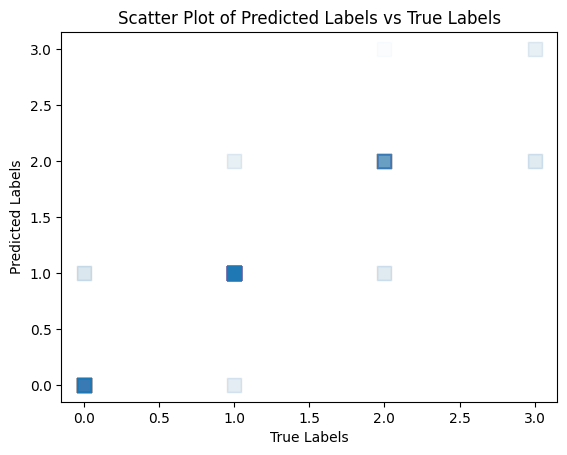

In [21]:
# tune regularization for multinomial logistic regression
from numpy import mean, std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
import numpy as np

# Define dataset
# X, y = skewness_series.reshape(-1, 1), frustr_series

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

# Get the model to evaluate
model = LogisticRegression(solver='lbfgs', max_iter=1000, penalty=None)
# model = LogisticRegression(solver='lbfgs', penalty='l2', C=1)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Plot scatter plot of predicted labels vs true labels
pyplot.scatter(y_test, y_pred, marker='s', alpha=0.02, color='C0', s=100)
pyplot.xlabel('True Labels')
pyplot.ylabel('Predicted Labels')
pyplot.title('Scatter Plot of Predicted Labels vs True Labels')
pyplot.show()